## Inference and validation

Here we will use our neural network to make predictions (inference)

To avoid overfitting, we will use a validation set to test the performance during training

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [2]:
# Creating a model as usual
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. 

Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the 𝑘 highest values. Since we just want the most likely class, we can use ps.topk(1)

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[3],
        [3],
        [3],
        [3],
        [3],
        [1],
        [3],
        [3],
        [3],
        [3]])


Now we can check if the predicted classes match the labels

We have to be careful of the shapes. Here top_class is a 2D tensor with shape (64, 1) while labels is 1D with shape (64)

In [5]:
# equals will have shape (64, 64)
# It is comparing the one element in each row of top_class with each element in labels 
# returns 64 True/False boolean values for each row.
equals = top_class == labels.view(*top_class.shape)

In [6]:
# calculating the percentage of correct predictions
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


In [7]:
# Implementing validation and printing out accuracy in each loop

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        print(f'Accuracy: {accuracy.item()*100}%')

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.461..  Test Accuracy: 0.822
Accuracy: 12903.125%
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.411..  Test Accuracy: 0.848
Accuracy: 13315.625%
Epoch: 3/30..  Training Loss: 0.356..  Test Loss: 0.399..  Test Accuracy: 0.854
Accuracy: 13400.0%
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.421..  Test Accuracy: 0.857
Accuracy: 13448.4375%
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.379..  Test Accuracy: 0.867
Accuracy: 13617.1875%
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.371..  Test Accuracy: 0.868
Accuracy: 13625.0%
Epoch: 7/30..  Training Loss: 0.288..  Test Loss: 0.390..  Test Accuracy: 0.865
Accuracy: 13579.6875%
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.355..  Test Accuracy: 0.879
Accuracy: 13800.0%
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.362..  Test Accuracy: 0.875
Accuracy: 13734.375%
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.341..  Test Accuracy: 0.880
Accuracy: 138

## Overfitting

Neural networks tend to overfit because they become too familiar with the training data and they hace problems generalizing.

The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the nn.Dropout module.

In [8]:
# Adding dropout to our model

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [9]:
# Training and see if we can get better accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.604..  Test Loss: 0.470..  Test Accuracy: 0.832
Epoch: 2/30..  Training Loss: 0.484..  Test Loss: 0.452..  Test Accuracy: 0.843
Epoch: 3/30..  Training Loss: 0.455..  Test Loss: 0.407..  Test Accuracy: 0.856
Epoch: 4/30..  Training Loss: 0.435..  Test Loss: 0.400..  Test Accuracy: 0.855
Epoch: 5/30..  Training Loss: 0.418..  Test Loss: 0.415..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.410..  Test Loss: 0.380..  Test Accuracy: 0.865
Epoch: 7/30..  Training Loss: 0.403..  Test Loss: 0.411..  Test Accuracy: 0.862
Epoch: 8/30..  Training Loss: 0.396..  Test Loss: 0.390..  Test Accuracy: 0.865
Epoch: 9/30..  Training Loss: 0.396..  Test Loss: 0.406..  Test Accuracy: 0.857
Epoch: 10/30..  Training Loss: 0.391..  Test Loss: 0.371..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.381..  Test Loss: 0.386..  Test Accuracy: 0.871
Epoch: 12/30..  Training Loss: 0.379..  Test Loss: 0.393..  Test Accuracy: 0.862
Epoch: 13/30..  Training Loss: 0.379.

## Inference

Now that the model is trained, we can use it for inference. We need to remember to set the model in inference mode with model.eval(). You'll also want to turn off autograd with the torch.no_grad() context.

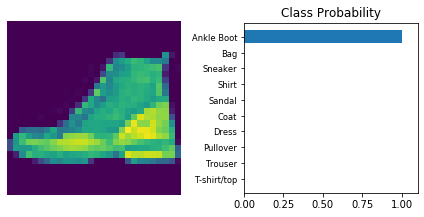

In [11]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')